# Air Quality Solutions
## Python Workshop \#4 - Model-measurement comparison

In this workshop, we will compare model data with measured/observed data, and learn how to use observations to evaluate model performance. 

### Content
* Plotting model + observational data on a map
* Plotting time series of model and observational data
* Interpolating model data to match observations
* Model-observation scatterplots
* Model evaluation metrics for bias and correlation
* Diagnosing model issues using comparison metrics

### Data
We will bring together data from previous workshops, including
- CNEMC air quality data from `./data/workshop_2`
- WRF-Chem model scenario data used in `./data/workshop_3`

----
### Overlaying model data with observations
First let's load in data that we are using for this workshop. As in the previous workshops, the WRF-Chem data is stored in a NetCDF file. The file contains data for PM2.5, O3, NO2 and SO2 data. The model data has already been converted into consistent units (ug m-3)

The observational data is stored in a `.parquet` file (unlike the `.csv` files we used before). This preserves the hierachical multi-index so allows for the data to be stored together in one file.

In [1]:
import xarray as xr
import pandas as pd

# load in model data
mod = xr.open_dataset('./data/workshop_4/wrfchem_2015.nc')
# load in CNEMC obs data
obs = pd.read_parquet('./data/workshop_4/cnemc_obs.parquet') 
meta = pd.read_csv('./metadata.csv', index_col='station_id')

# get a list of pollutants
pols = list(mod.data_vars)

#### <font color='red'>Question 1</font>
**To get an overview of the data available, plot the annual mean of the model data (as a grid), with the annual mean of the measurement data overlayed as scattered points.**

Plot one panel for each pollutant, and represent the concentration with a colourmap. Ensure that the has the same limits for the measurement and model data. 

Hints:
* Make sure that the axes are geographically projected using cartopy.
* You can use the cartopy model `cartopy.feature` to easily add borders and coastlines to your map
* Transforming the points you want to plot into a geopandas geodataframe makes it easier to plot them on a map. You can make the geodataframe from the measurement metadata (`meta`). The code to do this is in workshop 2, but this time filter by the stations present in `obs`
* choose appropriate limits (`vmin` and `vmax`) by calculating min+max or percentiles (e.g. 5th and 95th) of the annual means values that are being plotted from the model and observational data, then choose the minimum (in the case of `vmin`) and maximum (`vmax`) from these.
#### <font color='green'>Answer 1</font>

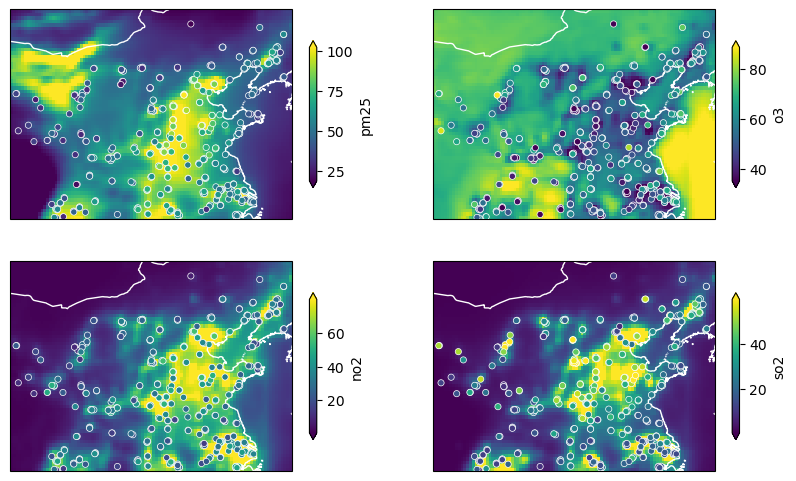

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd

stations  = obs.columns.get_level_values(0).unique()
meta = meta.loc[stations] # ok to overwrite meta here as won't need other data
gdf = gpd.GeoDataFrame(meta, geometry=gpd.points_from_xy(x=meta.lon, y=meta.lat),
                       crs='EPSG:4326' # this tells geopandas we are using latitude-longitude coordinates
                      )
for pol in pols:
    gdf[f'annual_mean_{pol}'] = obs.xs(level='pollutant', key=pol, axis=1).mean()
    

china_proj = ccrs.Orthographic(central_latitude=36, central_longitude=106)
pols = ['pm25', 'o3', 'no2', 'so2']

fig, axes = plt.subplots(2,2, subplot_kw={'projection':ccrs.PlateCarree()},
                        figsize=[10,6])

for pol, ax in zip(pols, axes.ravel()):

    mod_annual_mean = mod[pol].mean('time')

    # calc appropriate limits
    obs_ll, obs_ul = gdf[f'annual_mean_{pol}'].quantile([.05, .95])
    mod_ll, mod_ul = mod_annual_mean.quantile(dim=['lon', 'lat'], q=['.05', '.95'])
    vmin, vmax = min(obs_ll, mod_ll), max(obs_ul, mod_ul)


    mod_annual_mean.plot(ax=ax, transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax, cbar_kwargs={'shrink':.7})
    ax.add_feature(cf.BORDERS, edgecolor='white')
    ax.add_feature(cf.COASTLINE, edgecolor='white')

    gdf.plot(column=f'annual_mean_{pol}', ax=ax, s=20, edgecolor='white',
            lw=.5, vmin=vmin, vmax=vmax, zorder=10)

From the plots you have just created it appears that the model can capture some of the observed spatial distribution.

To see whether the model can capture the temporal distribution in the observations, we can compare the average of the model (mean over lat and lon) concentrations to the average of all the observation station timeseries, like this:

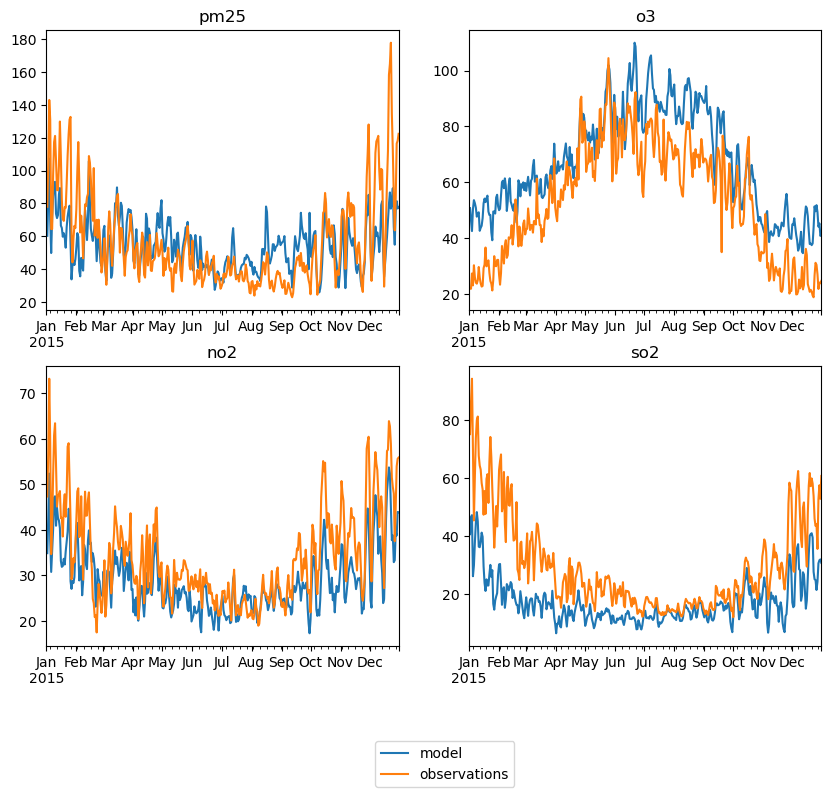

In [3]:
fig, axes = plt.subplots(2,2, figsize=[10,8])

for pol, ax in zip(pols, axes.ravel()):
    # plot model daily means
    mod[pol].mean(['lat', 'lon']).to_pandas().resample('D').mean().plot(ax=ax, label='model')
    # plot measurement daily means
    obs.xs(level='pollutant', key=pol, axis=1).mean(1).resample('D').mean().plot(ax=ax, label='observations')

    ax.set_title(pol)
    ax.set_xlabel('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=[.6, 0])

### Interpolation

There is a problem with the comparison that the time series plots show above. We are comparing the average of all the model gridcells with the average of all the monitoring station data. However, the monitoring stations are not necessarily evenly distributed with respect to the model data. For example, the monitoring stations could be mostly in big cities with high pollution levels, while the average of all model gridcells includes more remote areas.

To fix this issue, we need to extract time series from the model data that match the distribution of the measurement data. One approach could be to find which model grid cell a station overlaps with, and extract the time series from there. But an issue with this is that each model grid cell represents the average over a large area (in this case ~30km). As can be seen from the maps above, air pollution concentrations can vary sharply in space. Imagine two neighbouring model gridcells that have very different concentrations, but there is a measurement station near the boundary. It would make more sense to take an average between the two grid cells to get an estimate from the model of what the observation station concentration might be.

To do this we need to use **interpolation**, which is used to estimate unknown values between known the known data points. However, interpolation of geographically projected data such as the WRF-Chem output is a little complicated, so we can use the following function to generate an interpolated dataframe of model values to match the observation timeseries

In [4]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def get_interpolated_model_timeseries(mod, obs, meta):

    srs = []
    for pol in pols:
        da = mod[pol]
        timemap = pd.Series(da.time.values)
        points = (timemap.index.values, da.lat.values, da.lon.values)
        interper = RegularGridInterpolator(points=points, values=da.values,
                                           method='linear', bounds_error=False, fill_value=np.nan)
        
        for station in meta.index:
            lat, lon = meta.loc[station, ['lat', 'lon']]
            interped = interper((timemap.index.values, lat, lon))
            sr = pd.Series(interped, index=timemap.values)
            sr.name = (station, pol)
            srs.append(sr)
    
    df = pd.concat(srs, axis=1)
    df = df.sort_index(axis=1, level=0)
    df.columns = df.columns.set_names(['station', 'pollutant'])

    return df

mod_interped = get_interpolated_model_timeseries(mod, obs, meta)

Now we can recreate the figure including the interpolated model data:

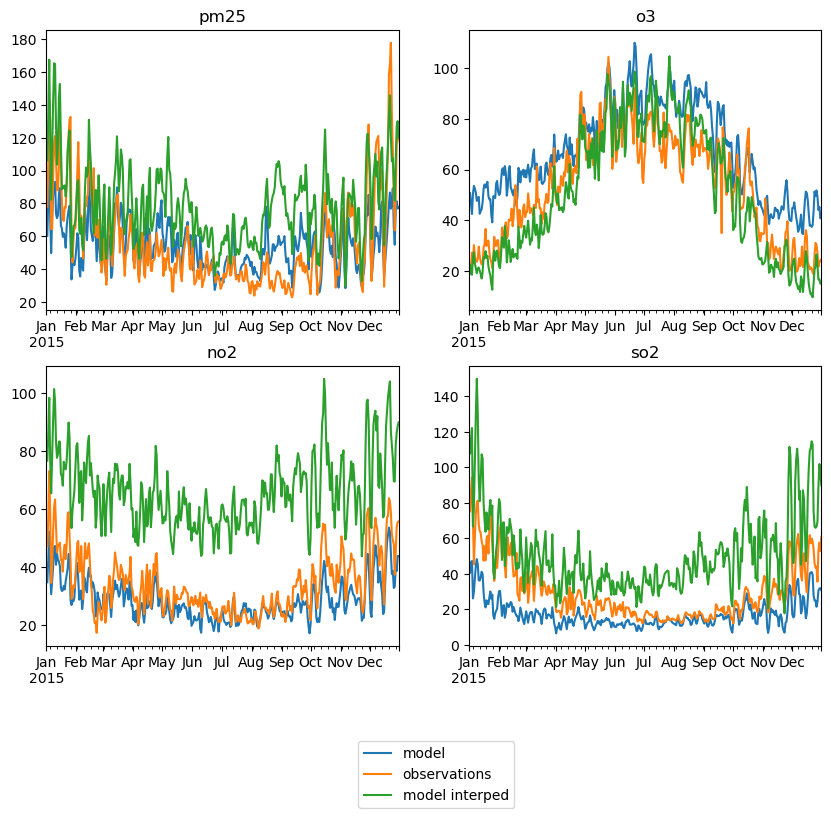

In [5]:
fig, axes = plt.subplots(2,2, figsize=[10,8])

for pol, ax in zip(pols, axes.ravel()):
    # plot model daily means
    mod[pol].mean(['lat', 'lon']).to_pandas().resample('D').mean().plot(ax=ax, label='model')
    # plot measurement daily means
    obs.xs(level='pollutant', key=pol, axis=1).mean(1).resample('D').mean().plot(ax=ax, label='observations')

    mod_interped.xs(level='pollutant', key=pol, axis=1).mean(1).resample('D').mean().plot(ax=ax, label='model interped')

    ax.set_title(pol)
    ax.set_xlabel('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=[.6, 0])

You can see that the <font color='green'>interpolated model data</font> doesn't necessarily match the <font color='orange'>observations</font> better better than than the <font color='blue'>un-interpolated model data</font> in this case. But is is still a truer representation of the model predictions of the concentrations.

Now that we have two comparable `DataFrames`, `mod_interped` and `obs` we can start to do more detailed comparisons of the model and measurement data. A good first step is to make a scatter plot comparing modelled and observed concentration.

**But first!** Model data is often not in the same time zone as measurement data. The model data is in UTC time zone (+0), whereas the observational data is in the 'Asia/Shanghai' timezone (+8). Currently both dataframes have a timezone 'naive' `DatetimeIndex`. By converting the model data to the 'Asia/Shanghai' timezone we can ensure we are comparing data from the same local time. Since pandas doesn't allow operations that require checking indices overlap between timezone naive and timezone aware timeseries, we must also make the `obs` dataframe index timezone aware

In [6]:
mod_interped.index = mod_interped.index.tz_localize('UTC').tz_convert('Asia/Shanghai')
obs.index = obs.index.tz_localize('Asia/Shanghai')

#### <font color='red'>Question 2</font>
**Make a scatterplot comparing modelled and observed annual mean concentrations for the four pollutants**.
Use the `obs` data for the observations and `mod_interped` for the model data. Plot the observations on the x axis and the model values on the y axis.

Tips:
* When you plot x and y using `ax.scatter(x, y, ....)`, make sure that x and y are in the same order so that the stations are correctly being compared with eachother.
* To keep the plot square, make sure axis limits are consistent for each pollutant, and use `ax.set_aspect(1)`
* Add a 1:1 line to show where points would be placed if agreement were perfect

#### <font color='green'>Answer 2</font>

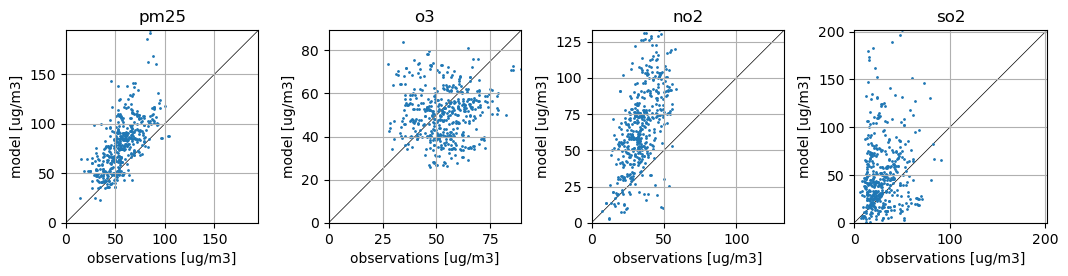

In [7]:
fig, axes = plt.subplots(1,4, figsize=[13,2.5])
mod_interped.xs(level='pollutant', key=pol, axis=1).mean()

for pol, ax in zip(pols, axes.ravel()):
    mean_mod = mod_interped.xs(level='pollutant', key=pol, axis=1).mean()
    mean_obs = obs.xs(level='pollutant', key=pol, axis=1).mean()
    mean_mod = mean_mod.loc[mean_obs.index]

    # find upper limit from the max of both maxes
    mod_ul, obs_ul = mean_mod.max(), mean_obs.max()
    ul = max(obs_ul, mod_ul)

    # set axis limits to ensure square
    ax.set_aspect(1)
    ax.set_xlim(0, ul)
    ax.set_ylim(0, ul)
    
    # plot the points
    ax.scatter(mean_obs, mean_mod, s=1)

    # plot the 1:1 line
    ax.plot([0, ul], [0, ul], zorder=0, color='black', lw=.5)

    # make the plot look good
    ax.grid()
    ax.set_xlabel('observations [ug/m3]')
    ax.set_ylabel('model [ug/m3]')
    ax.set_title(pol)

### Model evaluation metrics

We should be able to see from the plots above that the modelled concentrations are clearly biased high for PM2.5 and NO2, but it would be useful to be able to put a number on how biased/accurate the models are to facilitate comparison. These scatterplots offer a useful starting point, but they only evaluate the model on an annual mean basis, so could be masking issues that occur on different timescales. For example, if the model is biased high at night but biased low in the daytime, it may appear to be performing well on a daily mean basis. Therefore, to comprehensively evaluate the model's performance it is necessary to calculate comparison metrics.

Additionally, there are multiple aspects to a model's performance. For example, it could be biased low or high, causing it to under or over-estimate pollutant concentrations. Or it could be lacking the ability to capture temporal or spatial variability. Models could perform well on one dimension (e.g. capturing the diurnal cycle) but poorly on another (e.g. not able to capture spatial distributions).

#### Bias
Bias describes a type of innaccuracy in models where they consistently predict too high (positive bias) of too low (negative bias) values. This can be measured using a metric called Normalised Mean Bias (NMB). A NMB score of 1 indicates the model is unbiased


$$
\mathrm{NMB} = \frac{\sum_{i=1}^{n} (M_i - O_i)}{\sum_{i=1}^{n} O_i}
$$
$$
\text{where:} \quad
\begin{aligned}
    M_i & \text{ is the model prediction for the } i\text{th observation,} \\
    O_i & \text{ is the observed value for the } i\text{th observation,} \\
    n & \text{ is the total number of observations.}
\end{aligned}
$$

NMB is usually expressed as a dimensionless number but can also be expressed as a percentage. An NMB of 0 indicates that the model is completely unbiased, whereas a value of -1 or 1 means the model is negatively or positively biased by a factor of 2.

#### <font color='red'>Question 3</font>
Write a python function called `calc_nmb` which accepts a model pandas DataFrame and observation DataFrame as its arguments and returns an NMB score for each station in the data. Use this to compute the mean NMB of the 4 pollutants, and store the results in a DataFrame with its a column for each pollutant. Print the values of NMB calculated from daily mean data and hourly data, then plot a boxplot (`ax.boxplot()`) for each pollutant of the daily NMB to show the distribution of NMB values.

tips:
* If the NMB values are correctly stored in a pandas dataframe, the boxplot can be generated simply by using `df.plot.box()`

#### <font color='green'>Answer 3</font>

The mean (across all stations) NMB calculated from hourly data is:
pm25: 0.44
o3: -0.02
no2: 0.98
so2: 1.13
The mean (across all stations) NMB calculated from daily data is:
pm25: 0.44
o3: -0.01
no2: 0.96
so2: 1.12


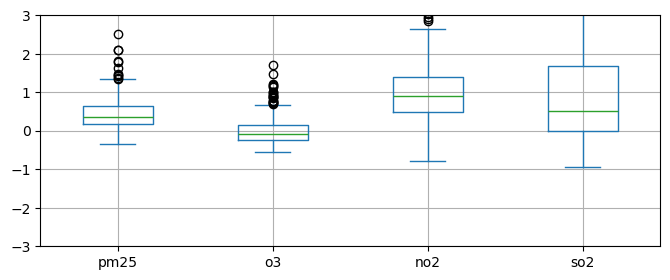

In [8]:
def calc_nmb(mod, obs):
    nmb = (mod - obs).sum() / obs.sum()
    return nmb

# calc hourly nmb
nmbs_hourly = pd.DataFrame()
for pol in pols:
    nmb = calc_nmb(mod=mod_interped.xs(level='pollutant', key=pol, axis=1),
                   obs=obs.xs(level='pollutant', key=pol, axis=1))
    nmbs_hourly[pol] = nmb

# calc daily nmb
nmbs_daily = pd.DataFrame()
for pol in pols:
    nmb = calc_nmb(mod=mod_interped.xs(level='pollutant', key=pol, axis=1).resample('D').mean(),
                   obs=obs.xs(level='pollutant', key=pol, axis=1).resample('D').mean())
    nmbs_daily[pol] = nmb



print('The mean (across all stations) NMB calculated from hourly data is:')
[print(f'{pol}: {round(nmbs_hourly[pol].mean(), 2)}') for pol in pols]

print('The mean (across all stations) NMB calculated from daily data is:')
[print(f'{pol}: {round(nmbs_daily[pol].mean(), 2)}') for pol in pols]

fig, ax = plt.subplots(figsize=[8,3])
nmbs_daily.plot.box(ax=ax)
ax.set_ylim(-3, 3)
ax.grid()

#### Correlation
Another important aspect of a models' skill is its ability to match the observed fluctuation in pollutant concentrations. If a model can mirror the fluctuations in observed concentrations, there is a strong positive correlation, while if a model has no ability to follow observations it has 0 correlation. If a model has a negative correlation, this means it typically moves in the opposite direction to observed fluctuations!

Note that, just because a correlation might be high, it doesn't necessarily mean that the model is good (see bottom left plot below!)

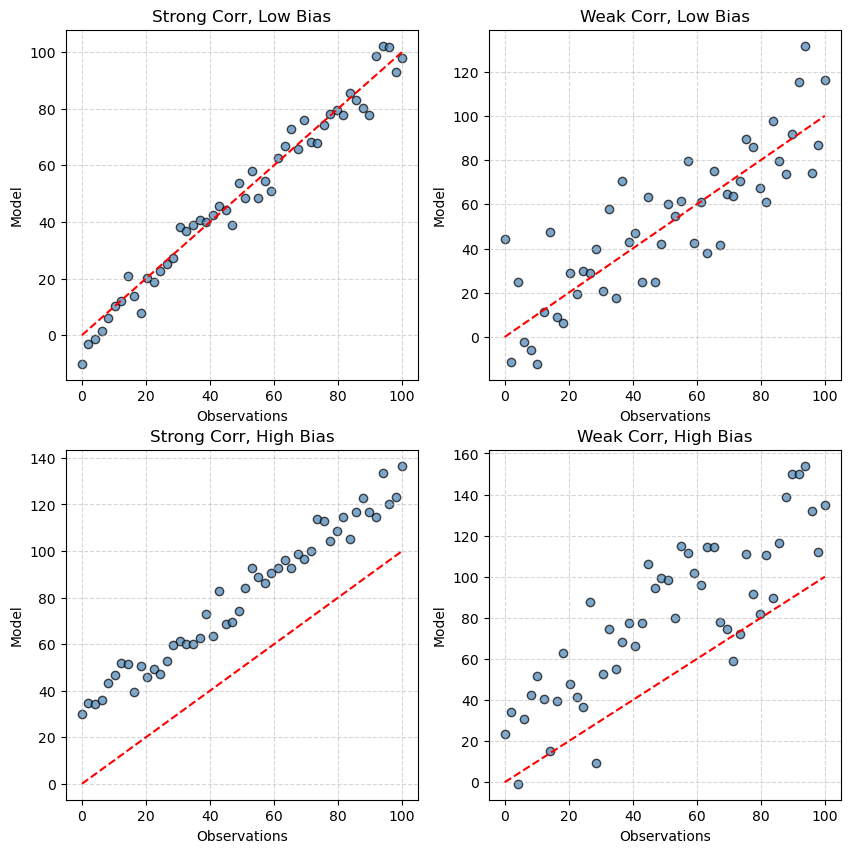

In [9]:
demo_obs = np.linspace(0, 100, 50)
scenarios = {
    "Strong Corr, Low Bias": demo_obs + np.random.normal(0, 5, demo_obs.shape),
    "Weak Corr, Low Bias": demo_obs + np.random.normal(0, 20, demo_obs.shape),
    "Strong Corr, High Bias": demo_obs + 30 + np.random.normal(0, 5, demo_obs.shape),
    "Weak Corr, High Bias": demo_obs + 30 + np.random.normal(0, 20, demo_obs.shape),
}

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax, (title, mod) in zip(axs.flat, scenarios.items()):
    ax.scatter(demo_obs, mod, color="steelblue", edgecolor="black", alpha=0.7)
    ax.plot(demo_obs, demo_obs, "r--")
    ax.set(title=title, xlabel="Observations", ylabel="Model")
    ax.grid(True, linestyle="--", alpha=0.5)

A good statistic to use for correlation is Pearson's r, which is calculated with the following equation:

$$
r = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum_{i=1}^{n} (X_i - \bar{X})^2 \sum_{i=1}^{n} (Y_i - \bar{Y})^2}}
$$


$$
\text{where:} \quad
\begin{aligned}
    r &\text{ is the Pearson correlation coefficient,} \\
    X_i &\text{ is the } i\text{-th value of variable } X, \\
    Y_i &\text{ is the } i\text{-th value of variable } Y, \\
    \bar{X} &\text{ is the mean of variable } X, \\
    \bar{Y} &\text{ is the mean of variable } Y, \\
    n &\text{ is the number of data points.}
\end{aligned}
$$

The value of `r` can range from -1 (perfect negative correlation) to 1 (perfect positive correlation). A skill of >~0.7 is usually considered decent model performance. 

Luckily, pandas containts a method that can be easily used to calculate r without rewriting the equation! All of the correlation co-efficients can be calculated in one line:

In [10]:
r = mod_interped.corrwith(obs)

This produces a pandas series with a multi-index that can be indexed using `idx` as previously demonstrated. This makes it easy to calculate the mean r score for each pollutant:

In [11]:
print(r.groupby(level='pollutant').mean())

pollutant
no2     0.418469
o3      0.660234
pm25    0.440155
so2     0.298277
dtype: float64


This shows that the correlation scores are not great on an hourly basis. Let's see if the daily mean correlation is better:

In [12]:
r = mod_interped.resample('D').mean().corrwith(obs.resample('D').mean())
print(r.groupby(level='pollutant').mean())

pollutant
no2     0.548378
o3      0.668763
pm25    0.524839
so2     0.544330
dtype: float64


It is slightly better for some pollutants, which suggests that the model is better at getting the daily mean concentration right, but can't always reproduce the diurnal cycle.

#### <font color='red'>Question 4</font>
Exploring how correlation and bias vary diurnally and seasonally can help us understand which model processes are leading to innaccuracy. For example, if the model has a high positive bias at night, it could be because the boundary layer height is too low, or if the model performs worse in the summer, it could be because more dynamic weather patterns are not being captured.

**Adapt the code for calculating `r` above to make a plot of how the the correlation varies diurnally and seasonally for one of the pollutants (choose one). On a secondary y axis, add the NMB.**
Make a figure with two subplots, plot the monthly average skill scores on one, and the diurnal average skill scores on another. Take the average of the skill scores across all the stations.

Hints:
* generate a secondary y axis using `.twinx()`
* differentiate the line representing NMB from correlation using colour, linestyle, etc.

#### <font color='green'>Answer 4</font>

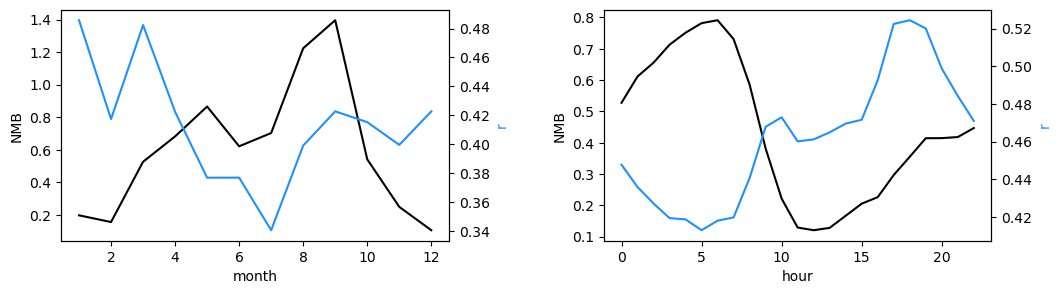

In [13]:
pol = 'pm25'

# index to make dataframes of just 'pol'
pdf_mod = mod_interped.xs(level='pollutant', key=pol, axis=1)
pdf_obs = obs.xs(level='pollutant', key=pol, axis=1)

fig, axes = plt.subplots(1,2, figsize=[12,3])

### seasonal axis ###
months = range(1, 13)
y_nmb = []
y_r = []
for month in months:
    # make mod and meas dataframes with data from a single month
    mdf_mod = pdf_mod.loc[pdf_mod.index.month == month]
    mdf_obs = pdf_obs.loc[pdf_obs.index.month == month]

    # nmb
    nmb = y_nmb.append(calc_nmb(mod=mdf_mod, obs=mdf_obs).mean())
    # correlation
    r = y_r.append(mdf_mod.corrwith(mdf_obs).mean())

nmb_ax = axes[0]
r_ax = nmb_ax.twinx()

nmb_ax.plot(months, y_nmb, label='bias', color='black')
r_ax.plot(months, y_r, label='correlation', color='dodgerblue')

nmb_ax.set_ylabel('NMB', color='black')
r_ax.set_ylabel('r', color='dodgerblue')
nmb_ax.set_xlabel('month')

### diurnal axis ###
hours = range(0, 23)
y_nmb = []
y_r = []
for hour in hours:
    # make mod and meas dataframes with data from a single month
    hdf_mod = pdf_mod.loc[pdf_mod.index.hour == hour]
    hdf_obs = pdf_obs.loc[pdf_obs.index.hour == hour]

    # nmb
    nmb = y_nmb.append(calc_nmb(mod=hdf_mod, obs=hdf_obs).mean())
    # correlation
    r = y_r.append(hdf_mod.corrwith(hdf_obs).mean())

nmb_ax = axes[1]
r_ax = nmb_ax.twinx()

nmb_ax.plot(hours, y_nmb, label='bias', color='black')
r_ax.plot(hours, y_r, label='correlation', color='dodgerblue')

nmb_ax.set_ylabel('NMB', color='black')
r_ax.set_ylabel('r', color='dodgerblue')
nmb_ax.set_xlabel('hour')

fig.subplots_adjust(wspace=.4)